In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.optim import Adam
from torch.autograd import Variable
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder

from sklearn.model_selection import train_test_split

from pathlib import Path
import gdown

import time

from typing import Type

In [2]:
%%capture
RESISC45_DIR = Path(".") / "NWPU-RESISC45"
if not RESISC45_DIR.exists():
    gdown.download(
        id="1nd0R9iljzkWd7Hhfyp2tH55KxAsKrzYj",
        output="NWPU-RESISC45.rar",
    )
    !unrar x NWPU-RESISC45.rar

In [3]:
# Find mean and standard deviation of data
def get_mean_and_std():
    transformations = transforms.Compose([transforms.ToTensor()])
    dataset = ImageFolder(root="NWPU-RESISC45", transform=transformations)
    loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

    mean = 0.0
    std = 0.0
    total_samples = 0

    for images, _ in loader:
        batch_size = images.size(0)
        images = images.view(batch_size, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_samples += batch_size

    mean /= total_samples
    std /= total_samples

    print(f"Mean: {mean}")
    print(f"Std: {std}")


def split_data(data, train_size=0.8):
    target_array = data.targets

    train_indices, test_indices = train_test_split(
        range(len(target_array)),
        train_size=train_size,
        random_state=69,
        stratify=target_array,
    )

    return train_indices, test_indices

In [4]:
mean = (0.3680, 0.3810, 0.3436)
std = (0.1454, 0.1356, 0.1320)

train_ratio = 0.8
test_ratio = 0.2

# Learning settings
batch_size = 64
learning_rate = 0.0004

channel_sizes = (32, 16, 8)
linear_sizes = (8712, 512)
normalizer = nn.Identity

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # to use M1 mac gpu
else:
    device = torch.device("cpu")

In [5]:
transformations = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean, std)]
)

rotate_90 = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        transforms.RandomRotation((90, 90)),
    ]
)

rotate_180 = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        transforms.RandomRotation((180, 180)),
    ]
)

rotate_270 = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        transforms.RandomRotation((270, 270)),
    ]
)

dataset = ImageFolder(root="NWPU-RESISC45", transform=transformations)
rotate_90_dataset = ImageFolder(root="NWPU-RESISC45", transform=rotate_90)
rotate_180_dataset = ImageFolder(root="NWPU-RESISC45", transform=rotate_180)
rotate_270_dataset = ImageFolder(root="NWPU-RESISC45", transform=rotate_270)

# get indices of split
train_indices, test_indices = split_data(dataset, train_size=train_ratio)

# Loading and normalizing the data.
classes = dataset.class_to_idx

# Create a sampler out of the indices
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_indices)

# give sampler to dataloader
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
train_90_loader = DataLoader(
    rotate_90_dataset, batch_size=batch_size, sampler=train_sampler
)
train_180_loader = DataLoader(
    rotate_180_dataset, batch_size=batch_size, sampler=train_sampler
)
train_270_loader = DataLoader(
    rotate_270_dataset, batch_size=batch_size, sampler=train_sampler
)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

In [6]:
# Define a convolution neural network
class Network(nn.Module):
    def __init__(
        self,
        linear_sizes,
        channel_sizes,
        activation=F.relu,
        norm: Type[nn.Module] = nn.BatchNorm2d,
    ):
        super().__init__()

        self.linear_sizes = linear_sizes
        self.activation = activation

        self.pool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(p=0.2)

        c1, c2, c3 = channel_sizes

        # First convolution
        self.conv1 = nn.Conv2d(3, c1, kernel_size=3, padding=1)
        self.norm1 = norm(c1)

        self.conv2 = nn.Conv2d(c1, c1, kernel_size=3, padding=1)
        self.norm2 = norm(c1)

        # Second convolution
        self.conv3 = nn.Conv2d(c1, c2, kernel_size=3, padding=1)
        self.norm3 = norm(c2)

        self.conv4 = nn.Conv2d(c2, c2, kernel_size=2, padding=1)
        self.norm4 = norm(c2)

        # Third convolution
        self.conv5 = nn.Conv2d(c2, c3, kernel_size=2, padding=1)
        self.norm5 = norm(c3)

        self.conv6 = nn.Conv2d(c3, c3, kernel_size=2, padding=1)
        self.norm6 = norm(c3)

        # Linear
        lin0, lin1 = linear_sizes

        self.fc1 = nn.Linear(lin0, lin1)
        self.fc2 = nn.Linear(lin1, 45)

    def forward(self, x):
        batch_size = x.size(0)

        activation = self.activation
        maxpool = self.pool
        dropout = self.dropout

        # First convolution
        # https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout
        x = self.norm1(self.conv1(x))
        x = activation(x)
        x = dropout(x)

        x = self.norm2(self.conv2(x))
        x = activation(x)

        x = maxpool(x)
        x = dropout(x)

        # Second convolution
        # https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout
        x = self.norm3(self.conv3(x))
        x = activation(x)
        x = dropout(x)

        x = self.norm4(self.conv4(x))
        x = activation(x)

        x = maxpool(x)
        x = dropout(x)

        # Third convolution
        # https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout
        x = self.norm5(self.conv5(x))
        x = activation(x)
        x = dropout(x)

        x = self.norm6(self.conv6(x))
        x = activation(x)

        x = maxpool(x)
        x = dropout(x)

        # Linear
        x = x.reshape(batch_size, self.linear_sizes[0])

        x = activation(self.fc1(x))
        x = dropout(x)

        x = self.fc2(x)

        return x


# Instantiate a neural network model
model = Network(linear_sizes, channel_sizes, norm=normalizer)

In [7]:
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

In [8]:
# Function to save the model
def saveModel():
    path = "augmented_attempt_2.pth"
    torch.save(model.state_dict(), path)


# Function to test the model with the test dataset and print the accuracy for the test images
def trainAccuracy():
    model.eval()
    accuracy = 0.0
    total = 0.0

    with torch.no_grad():
        for data in train_loader:
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    # compute the accuracy over all train images
    accuracy = 100 * accuracy / total
    return accuracy


def testAccuracy():
    model.eval()
    accuracy = 0.0
    total = 0.0

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    # compute the accuracy over all test images
    accuracy = 100 * accuracy / total
    return accuracy


# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs):
    best_accuracy = 0.0

    # Define your execution device
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")  # to use M1 mac gpu
    else:
        device = torch.device("cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        model.train()

        running_loss = 0.0
        running_acc = 0.0

        for folder in [
            train_loader,
            train_90_loader,
            train_180_loader,
            train_270_loader,
        ]:
            for i, (images, labels) in enumerate(folder, 0):
                # get the inputs
                images = Variable(images.to(device))
                labels = Variable(labels.to(device))

                # zero the parameter gradients
                optimizer.zero_grad()
                # predict classes using images from the training set
                outputs = model(images)
                # compute the loss based on model output and real labels
                loss = loss_fn(outputs, labels)
                # backpropagate the loss
                loss.backward()
                # adjust parameters based on the calculated gradients
                optimizer.step()

                # Let's print statistics for every 1,000 images
                running_loss += loss.item()  # extract the loss value
                if i % 100 == 99:
                    # print every 100 images
                    print(
                        f"[Epoch {epoch + 1:2d}]: "
                        f"Average loss at {i + 1:3d} iterations: {running_loss / (i + 1):.3f}"
                    )

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        accuracy = trainAccuracy()
        print(
            "For epoch",
            epoch + 1,
            "the train accuracy over the whole test set is %d %%" % (accuracy),
        )
        accuracy = testAccuracy()
        print(
            "For epoch",
            epoch + 1,
            "the test accuracy over the whole test set is %d %%" % (accuracy),
        )

        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy

In [15]:
import matplotlib.pyplot as plt
import numpy as np


# Function to show the images
def show_image(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Function to test the model with a batch of images and show the labels predictions
def testBatch():
    class_list = list(classes.keys())

    # get batch of images from the test DataLoader
    images, labels = next(iter(test_loader))

    # show all images as one image grid
    show_image(torchvision.utils.make_grid(images))

    # Get a tuple of real labels
    real_labels = (class_list[labels[j]] for j in range(batch_size))

    # Let's see what if the model identifiers the  labels of those example
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)

    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    _, predicted = torch.max(outputs, 1)

    # Let's show the predicted labels on the screen to compare with the real ones
    predicted_labels = (class_list[predicted[j]] for j in range(batch_size))

    print(f"{'Real':25s}| {'Predicted':25s}| Match")
    print("-" * 25 + "+" + "-" * 27 + "+" + "-" * 6)

    for real, pred in zip(real_labels, predicted_labels, strict=True):
        match_char = "✅" if real == pred else "❌"
        print(f"{real:25s}|  {pred:25s}| {match_char}")

In [12]:
start_time = time.time()
# Train Model
train(20)
print("Finished Training")
print(f"Time Taken to train: {(time.time() - start_time)/60} minutes")
# Test which classes performed well
testAccuracy()

The model will be running on cuda device
[Epoch  1]: Average loss at 100 iterations: 3.650
[Epoch  1]: Average loss at 200 iterations: 3.522
[Epoch  1]: Average loss at 300 iterations: 3.398
[Epoch  1]: Average loss at 100 iterations: 15.824
[Epoch  1]: Average loss at 200 iterations: 9.247
[Epoch  1]: Average loss at 300 iterations: 7.028
[Epoch  1]: Average loss at 100 iterations: 25.849
[Epoch  1]: Average loss at 200 iterations: 14.100
[Epoch  1]: Average loss at 300 iterations: 10.171
[Epoch  1]: Average loss at 100 iterations: 34.874
[Epoch  1]: Average loss at 200 iterations: 18.546
[Epoch  1]: Average loss at 300 iterations: 13.076
For epoch 1 the train accuracy over the whole test set is 33 %
For epoch 1 the test accuracy over the whole test set is 32 %
[Epoch  2]: Average loss at 100 iterations: 2.076
[Epoch  2]: Average loss at 200 iterations: 2.062
[Epoch  2]: Average loss at 300 iterations: 2.059
[Epoch  2]: Average loss at 100 iterations: 10.056
[Epoch  2]: Average loss a

53.888888888888886

In [13]:
# Let's load the model we just created and test the accuracy per label
model = Network(linear_sizes, channel_sizes, norm=normalizer)
path = "augmented_attempt_2.pth"
model.load_state_dict(torch.load(path))
model.to(device)

Network(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): Identity()
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): Identity()
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): Identity()
  (conv4): Conv2d(16, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (norm4): Identity()
  (conv5): Conv2d(16, 8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (norm5): Identity()
  (conv6): Conv2d(8, 8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (norm6): Identity()
  (fc1): Linear(in_features=8712, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=45, bias=True)
)

In [16]:
# Test which classes performed well
train_accuracy = trainAccuracy()
print(f"Best train accuracy: {train_accuracy:.2f}%")

test_accuracy = testAccuracy()
print(f"Best test accuracy: {test_accuracy:.2f}%")

Best train accuracy: 78.02%
Best test accuracy: 55.16%


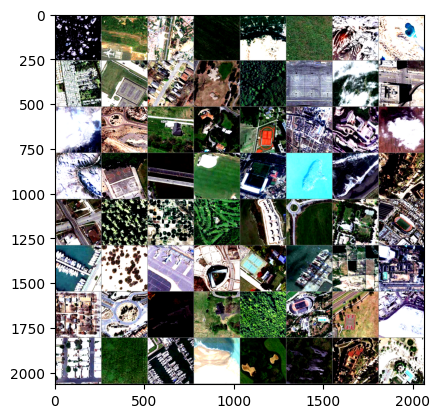

Real                     | Predicted                | Match
-------------------------+---------------------------+------
sea_ice                  |  sea_ice                  | ✅
airplane                 |  rectangular_farmland     | ❌
airport                  |  ground_track_field       | ❌
meadow                   |  meadow                   | ✅
river                    |  river                    | ✅
meadow                   |  meadow                   | ✅
snowberg                 |  storage_tank             | ❌
lake                     |  lake                     | ✅
mobile_home_park         |  mobile_home_park         | ✅
tennis_court             |  golf_course              | ❌
medium_residential       |  medium_residential       | ✅
golf_course              |  terrace                  | ❌
forest                   |  wetland                  | ❌
basketball_court         |  parking_lot              | ❌
cloud                    |  cloud                    | ✅
intersection            

In [17]:
testBatch()